# 识别笑容

## 图像预处理(crop the imgs)

导入必要包

In [2]:
import glob
import numpy as np
from PIL import Image
import torch
import os
from torch import nn
from torch.utils import data
from torchvision import transforms

导入数据类

In [3]:
class Mydataset(data.Dataset):
    def __init__(self, img_paths, labels, transform):
        self.imgs = img_paths
        self.labels = labels
        self.transforms = transform

    def __getitem__(self, item):
        img = self.imgs[item]
        label = self.labels[item]
        pil_img = Image.open(img)
        pil_img = pil_img.convert("RGB")
        data = self.transforms(pil_img)
        return data, label

    def __len__(self):
        return len(self.imgs)

基于VGG16模型，建立CNN类

In [4]:
class Vgg16_net(nn.Module):
    def __init__(self):
        super(Vgg16_net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, 2)
        )

        self.conv = nn.Sequential(
            self.layer1,
            self.layer2,
            self.layer3,
            self.layer4,
            self.layer5
        )

        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        # print(x.size())
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


定义训练函数，并且在训练过程中可以查看训练进度

In [6]:
from tqdm import tqdm

def fit(epoch, model, loss_fn, optim, train_dl, test_dl):
    model.train()
    train_correct = 0
    train_total = 0
    train_losses = []
    train_loader = tqdm(train_dl, desc=f'Epoch {epoch+1}/{epochs}', unit='batch')

    for x, y in train_loader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        optim.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y.long())
        loss.backward()
        optim.step()

        train_losses.append(loss.item())
        y_pred = torch.argmax(y_pred, dim=1)
        train_correct += (y_pred == y).sum().item()
        train_total += y.size(0)

        # 更新进度条
        train_loader.set_postfix(loss=np.mean(train_losses), acc=(train_correct / train_total))

        

    train_acc = train_correct / train_total

    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for x, y in test_dl:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
    test_acc = test_correct / test_total
    print('Epoch: ', epoch, 'Train Accuracy:', round(train_acc, 3), 'Test Accuracy:', round(test_acc, 3))
    return test_acc

划分数据集，按照70 15 15的比例

In [7]:
def read_first_column(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        first_column = [int(line.strip().split(' ')[0]) for line in lines]
    return first_column

imagePaths = glob.glob("Data/genki4k/files/*.jpg")
labelPaths = read_first_column("Data/genki4k/labels.txt")

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
index = np.random.permutation(len(imagePaths))
all_imgs_path = np.array(imagePaths)[index]
all_labels = np.array(labelPaths)[index]

# 保存
save_dir = 'save'
os.makedirs(save_dir, exist_ok=True)

# 定义训练集、验证集和测试集的大小
train_size = int(len(all_imgs_path) * 0.7)
val_size = int(len(all_imgs_path) * 0.15)

# 划分训练集、验证集和测试集
train_imgs = all_imgs_path[:train_size]
train_labels = all_labels[:train_size]
val_imgs = all_imgs_path[train_size:train_size+val_size]
val_labels = all_labels[train_size:train_size+val_size]
test_imgs = all_imgs_path[train_size+val_size:]
test_labels = all_labels[train_size+val_size:]

# 创建数据集
train_ds = Mydataset(train_imgs, train_labels, transform)
val_ds = Mydataset(val_imgs, val_labels, transform)
test_ds = Mydataset(test_imgs, test_labels, transform)

# 创建数据加载器
train_dl = data.DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = data.DataLoader(val_ds, batch_size=4, shuffle=False)
test_dl = data.DataLoader(test_ds, batch_size=4, shuffle=False)


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


创建模型，并进行训练

In [9]:
model = Vgg16_net()

model.to(device) # 移动模型到cuda
print()
if torch.cuda.is_available():
    model.to('cuda')
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 30

best_accuracy = 0.0
save_dir = 'save/Task1'
os.makedirs(save_dir, exist_ok=True)

for epoch in range(epochs):
    test_acc = fit(epoch, model, loss_fn, optim, train_dl, val_dl)
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        best_model_path = os.path.join(save_dir, 'model_best_accuracy.pth')
        torch.save(model.state_dict(), best_model_path)

    # 保存最后一个 epoch 的模型
    last_model_path = os.path.join(save_dir, 'model_last_epoch.pth')
    torch.save(model.state_dict(), last_model_path)

print(f"Best model saved to {best_model_path}")
print(f"Last epoch model saved to {last_model_path}")
print("Finish Training!")

Epoch 1/30: 100%|██████████| 700/700 [00:14<00:00, 49.06batch/s, acc=0.529, loss=0.699]


Epoch:  0 Train Accuracy: 0.529 Test Accuracy: 0.537


Epoch 2/30: 100%|██████████| 700/700 [00:13<00:00, 53.57batch/s, acc=0.548, loss=0.689]


Epoch:  1 Train Accuracy: 0.548 Test Accuracy: 0.525


Epoch 3/30: 100%|██████████| 700/700 [00:13<00:00, 50.81batch/s, acc=0.534, loss=0.691]


Epoch:  2 Train Accuracy: 0.534 Test Accuracy: 0.548


Epoch 4/30: 100%|██████████| 700/700 [00:10<00:00, 65.66batch/s, acc=0.565, loss=0.683]


Epoch:  3 Train Accuracy: 0.565 Test Accuracy: 0.52


Epoch 5/30: 100%|██████████| 700/700 [00:13<00:00, 52.91batch/s, acc=0.564, loss=0.679]


Epoch:  4 Train Accuracy: 0.564 Test Accuracy: 0.575


Epoch 6/30: 100%|██████████| 700/700 [00:13<00:00, 51.60batch/s, acc=0.569, loss=0.678]


Epoch:  5 Train Accuracy: 0.569 Test Accuracy: 0.553


Epoch 7/30: 100%|██████████| 700/700 [00:12<00:00, 54.16batch/s, acc=0.575, loss=0.68] 


Epoch:  6 Train Accuracy: 0.575 Test Accuracy: 0.597


Epoch 8/30: 100%|██████████| 700/700 [00:12<00:00, 55.34batch/s, acc=0.574, loss=0.675]


Epoch:  7 Train Accuracy: 0.574 Test Accuracy: 0.565


Epoch 9/30: 100%|██████████| 700/700 [00:13<00:00, 51.86batch/s, acc=0.599, loss=0.667]


Epoch:  8 Train Accuracy: 0.599 Test Accuracy: 0.595


Epoch 10/30: 100%|██████████| 700/700 [00:13<00:00, 52.71batch/s, acc=0.6, loss=0.668]  


Epoch:  9 Train Accuracy: 0.6 Test Accuracy: 0.617


Epoch 11/30: 100%|██████████| 700/700 [00:13<00:00, 51.33batch/s, acc=0.603, loss=0.658]


Epoch:  10 Train Accuracy: 0.603 Test Accuracy: 0.627


Epoch 12/30: 100%|██████████| 700/700 [00:13<00:00, 52.66batch/s, acc=0.654, loss=0.623]


Epoch:  11 Train Accuracy: 0.654 Test Accuracy: 0.662


Epoch 13/30: 100%|██████████| 700/700 [00:13<00:00, 51.06batch/s, acc=0.768, loss=0.499]


Epoch:  12 Train Accuracy: 0.768 Test Accuracy: 0.763


Epoch 14/30: 100%|██████████| 700/700 [00:13<00:00, 52.45batch/s, acc=0.807, loss=0.439]


Epoch:  13 Train Accuracy: 0.807 Test Accuracy: 0.802


Epoch 15/30: 100%|██████████| 700/700 [00:13<00:00, 52.00batch/s, acc=0.829, loss=0.4]  


Epoch:  14 Train Accuracy: 0.829 Test Accuracy: 0.805


Epoch 16/30: 100%|██████████| 700/700 [00:13<00:00, 51.95batch/s, acc=0.846, loss=0.37] 


Epoch:  15 Train Accuracy: 0.846 Test Accuracy: 0.823


Epoch 17/30: 100%|██████████| 700/700 [00:12<00:00, 58.28batch/s, acc=0.852, loss=0.339]


Epoch:  16 Train Accuracy: 0.852 Test Accuracy: 0.83


Epoch 18/30: 100%|██████████| 700/700 [00:10<00:00, 64.38batch/s, acc=0.877, loss=0.306]


Epoch:  17 Train Accuracy: 0.877 Test Accuracy: 0.843


Epoch 19/30: 100%|██████████| 700/700 [00:13<00:00, 53.81batch/s, acc=0.885, loss=0.285]


Epoch:  18 Train Accuracy: 0.885 Test Accuracy: 0.833


Epoch 20/30: 100%|██████████| 700/700 [00:13<00:00, 53.54batch/s, acc=0.893, loss=0.271]


Epoch:  19 Train Accuracy: 0.893 Test Accuracy: 0.847


Epoch 21/30: 100%|██████████| 700/700 [00:13<00:00, 50.39batch/s, acc=0.901, loss=0.247]


Epoch:  20 Train Accuracy: 0.901 Test Accuracy: 0.845


Epoch 22/30: 100%|██████████| 700/700 [00:14<00:00, 48.12batch/s, acc=0.912, loss=0.234]


Epoch:  21 Train Accuracy: 0.912 Test Accuracy: 0.858


Epoch 23/30: 100%|██████████| 700/700 [00:13<00:00, 50.71batch/s, acc=0.912, loss=0.223]


Epoch:  22 Train Accuracy: 0.912 Test Accuracy: 0.852


Epoch 24/30: 100%|██████████| 700/700 [00:14<00:00, 49.94batch/s, acc=0.924, loss=0.205]


Epoch:  23 Train Accuracy: 0.924 Test Accuracy: 0.845


Epoch 25/30: 100%|██████████| 700/700 [00:13<00:00, 50.56batch/s, acc=0.929, loss=0.185]


Epoch:  24 Train Accuracy: 0.929 Test Accuracy: 0.86


Epoch 26/30: 100%|██████████| 700/700 [00:14<00:00, 48.95batch/s, acc=0.931, loss=0.176]


Epoch:  25 Train Accuracy: 0.931 Test Accuracy: 0.858


Epoch 27/30: 100%|██████████| 700/700 [00:14<00:00, 49.05batch/s, acc=0.94, loss=0.156] 


Epoch:  26 Train Accuracy: 0.94 Test Accuracy: 0.86


Epoch 28/30: 100%|██████████| 700/700 [00:14<00:00, 48.57batch/s, acc=0.946, loss=0.147]


Epoch:  27 Train Accuracy: 0.946 Test Accuracy: 0.865


Epoch 29/30: 100%|██████████| 700/700 [00:14<00:00, 48.48batch/s, acc=0.956, loss=0.129] 


Epoch:  28 Train Accuracy: 0.956 Test Accuracy: 0.867


Epoch 30/30: 100%|██████████| 700/700 [00:13<00:00, 50.49batch/s, acc=0.955, loss=0.121] 


Epoch:  29 Train Accuracy: 0.955 Test Accuracy: 0.863
Best model saved to save/Task1/model_best_accuracy.pth
Last epoch model saved to save/Task1/model_last_epoch.pth
Finish Training!


测试并可视化

In [13]:
def test_model(model, test_dl):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in test_dl:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
    acc = correct / total
    print(f'Test Accuracy: {acc * 100:.2f}%')
model.load_state_dict(torch.load('save/model_epoch_9.pth'))
test_model(model, test_dl)

Test Accuracy: 97.67%


Test Accuracy: 97.67%


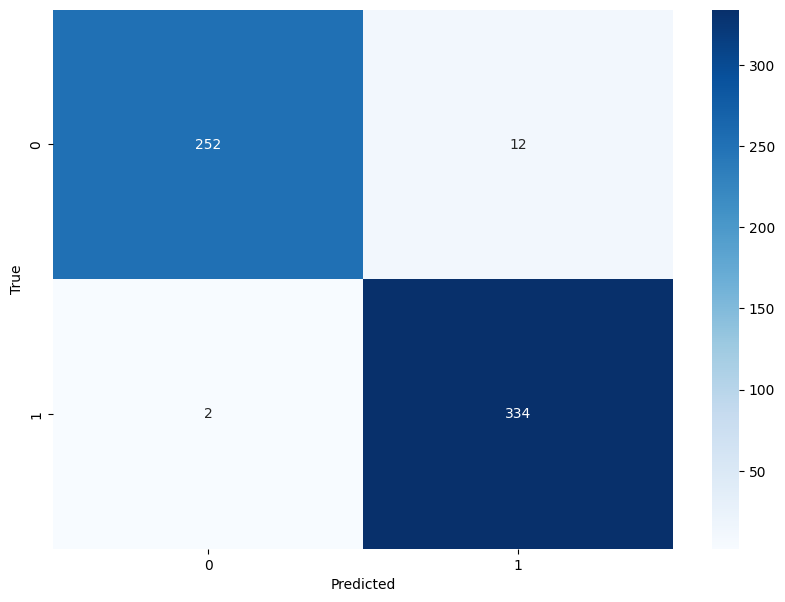

In [15]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def test_model(model, test_dl):
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in test_dl:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            predictions = torch.argmax(y_pred, dim=1)
            correct += (predictions == y).sum().item()
            total += y.size(0)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    acc = correct / total
    return all_labels, all_preds, acc

# 加载模型并在测试集上进行测试
model.load_state_dict(torch.load('save/model_epoch_9.pth'))
all_labels, all_preds, acc = test_model(model, test_dl)

# 输出准确度
print(f'Test Accuracy: {acc * 100:.2f}%')

# 生成混淆矩阵
conf_matrix = confusion_matrix(all_labels, all_preds)

# 可视化混淆矩阵
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
